# Import Library

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import time
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from albumentations import HorizontalFlip, CoarseDropout, Rotate, VerticalFlip
from patchify import patchify
from PIL import Image
from sklearn.model_selection import KFold
import matplotlib.image as mpimg

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers

# Preprocessing

## Load Image

In [2]:
# train_images = pd.DataFrame({
#     'sat_image_path': sorted(glob(os.path.join("./wbc_dataset/images/", "train/*.jpg"))), 
#     'mask_path': sorted(glob(os.path.join("./wbc_dataset/masks/", "train/*.png")))
# })

# valid_images = pd.DataFrame({
#     'sat_image_path': sorted(glob(os.path.join("./wbc_dataset/images/" "valid/*.jpg"))), 
#     'mask_path': sorted(glob(os.path.join("./wbc_dataset/masks/", "valid/*.png")))
# })

# test_images = pd.DataFrame({
#     'sat_image_path': sorted(glob(os.path.join("./wbc_dataset/images/", "test/*.jpg"))), 
#     'mask_path': sorted(glob(os.path.join("./wbc_dataset/masks/", "test/*.png")))
# })
    

# train_test_images = pd.concat([train_images, test_images], ignore_index=True)
    

## Split Train and Test in K-Fold

In [3]:
# k_train_images = []
# k_valid_images = []
# k_test_images = []


# kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
# for train, test in kf.split(train_test_images):
#     train_X, test_X = train_test_images['sat_image_path'][train], train_test_images['sat_image_path'][test]
#     train_y, test_y = train_test_images['mask_path'][train], train_test_images['mask_path'][test]
    
#     tmp_train_images = pd.DataFrame({
#         'sat_image_path': train_X, 
#         'mask_path': train_y
#     })
    
#     tmp_test_images = pd.DataFrame({
#         'sat_image_path': test_X, 
#         'mask_path': test_y
#     })
    
#     k_train_images.append(tmp_train_images)
#     k_valid_images.append(valid_images)
#     k_test_images.append(tmp_test_images)


## Resize Image

In [4]:
# def resize_img(images, fold=None, train=None, valid=None, test=None):
#     for img_path, mask_path in tqdm(images[['sat_image_path','mask_path']].to_numpy()):
#         name_img = img_path.split("\\")[-1].split('.')[0]
#         name_mask = mask_path.split("\\")[-1].split('.')[0]
#         # print(name_img)
#         image = cv2.imread(img_path, 1)
#         mask = cv2.imread(mask_path)
        
#         image = cv2.resize(image, (1024,1024))
#         mask = cv2.resize(mask, (1024,1024))
        
#         if train == True:
#             cv2.imwrite(f'./wbc_dataset/images1024/fold{fold}/train/{name_img}.jpg', image)
#             cv2.imwrite(f'./wbc_dataset/masks1024/fold{fold}/train/{name_mask}.png', mask)
#         elif valid == True:
#             cv2.imwrite(f'./wbc_dataset/images1024/fold{fold}/valid/{name_img}.jpg', image)
#             cv2.imwrite(f'./wbc_dataset/masks1024/fold{fold}/valid/{name_mask}.png', mask)
#         elif test == True:
#             cv2.imwrite(f'./wbc_dataset/images1024/fold{fold}/test/{name_img}.jpg', image)
#             cv2.imwrite(f'./wbc_dataset/masks1024/fold{fold}/test/{name_mask}.png', mask)
#         else:
#             return

In [5]:
# for i in range(5):
#     resize_img(k_train_images[i], fold=i+1, train=True)
#     resize_img(k_valid_images[i], fold=i+1, valid=True)
#     resize_img(k_test_images[i], fold=i+1, test=True)

## Patch Image

In [6]:
# train_images_1024 = []
# valid_images_1024 = []
# test_images_1024 = []

# for i in range(5):
#     tmp_train_images = pd.DataFrame({
#         'sat_image_path': sorted(glob(os.path.join("./wbc_dataset/images1024/fold{}".format(i+1), "train/*.jpg"))), 
#         'mask_path': sorted(glob(os.path.join("./wbc_dataset/masks1024/fold{}".format(i+1), "train/*.png")))
#     })

#     tmp_valid_images = pd.DataFrame({
#         'sat_image_path': sorted(glob(os.path.join("./wbc_dataset/images1024/fold{}".format(i+1), "valid/*.jpg"))), 
#         'mask_path': sorted(glob(os.path.join("./wbc_dataset/masks1024/fold{}".format(i+1), "valid/*.png")))
#     })

#     tmp_test_images = pd.DataFrame({
#         'sat_image_path': sorted(glob(os.path.join("./wbc_dataset/images1024/fold{}".format(i+1), "test/*.jpg"))), 
#         'mask_path': sorted(glob(os.path.join("./wbc_dataset/masks1024/fold{}".format(i+1), "test/*.png")))
#     })
    
#     train_images_1024.append(tmp_train_images)
#     valid_images_1024.append(tmp_valid_images)
#     test_images_1024.append(tmp_test_images)
    

In [7]:
# def patches(images1024, fold=None, train=None, valid=None, test=None):
#     for img_path, mask_path in tqdm(images1024[['sat_image_path','mask_path']].to_numpy()):
#         name_img = img_path.split("\\")[-1].split('.')[0]
#         name_mask = mask_path.split("\\")[-1].split('.')[0]
        
#         image = Image.open(img_path)  # for example (3456, 5184, 3)
#         image = np.asarray(image)
#         mask = Image.open(mask_path)
#         mask = np.asarray(mask)
#         patches_img = patchify(image, (512, 512, 3), step=512)
#         patches_mask = patchify(mask, (512, 512, 3), step=512)
        
#         print(patches_img.shape)  # (6, 10, 1, 512, 512, 3)
#         print(patches_mask.shape)

#         if train == True:
#             for i in range(patches_img.shape[0]):
#                 for j in range(patches_img.shape[1]):
#                     patch = patches_img[i, j, 0]
#                     patch = Image.fromarray(patch)
#                     num = i * patches_img.shape[1] + j
#                     patch.save(f"patch_data/fold{fold}/train/image/{name_img}_{num}.jpg")
                    
#             for k in range(patches_mask.shape[0]):
#                 for l in range(patches_mask.shape[1]):
#                     patch = patches_mask[k, l, 0]
#                     patch = Image.fromarray(patch)
#                     num = k * patches_mask.shape[1] + l
#                     patch.save(f"patch_data/fold{fold}/train/mask/{name_mask}_{num}.png")
#         elif valid == True:
#             for i in range(patches_img.shape[0]):
#                 for j in range(patches_img.shape[1]):
#                     patch = patches_img[i, j, 0]
#                     patch = Image.fromarray(patch)
#                     num = i * patches_img.shape[1] + j
#                     patch.save(f"patch_data/fold{fold}/valid/image/{name_img}_{num}.jpg")
                    
#             for k in range(patches_mask.shape[0]):
#                 for l in range(patches_mask.shape[1]):
#                     patch = patches_mask[k, l, 0]
#                     patch = Image.fromarray(patch)
#                     num = k * patches_mask.shape[1] + l
#                     patch.save(f"patch_data/fold{fold}/valid/mask/{name_mask}_{num}.png")
        
#         elif test == True:
#             for i in range(patches_img.shape[0]):
#                 for j in range(patches_img.shape[1]):
#                     patch = patches_img[i, j, 0]
#                     patch = Image.fromarray(patch)
#                     num = i * patches_img.shape[1] + j
#                     patch.save(f"patch_data/fold{fold}/test/image/{name_img}_{num}.jpg")
                    
#             for k in range(patches_mask.shape[0]):
#                 for l in range(patches_mask.shape[1]):
#                     patch = patches_mask[k, l, 0]
#                     patch = Image.fromarray(patch)
#                     num = k * patches_mask.shape[1] + l
#                     patch.save(f"patch_data/fold{fold}/test/mask/{name_mask}_{num}.png")
#         else:
#             return

In [8]:
# for i in range(5):
#     patches(train_images_1024[i], fold=i+1, train=True)
#     patches(valid_images_1024[i], fold=i+1, valid=True)
#     patches(test_images_1024[i], fold=i+1, test=True)

## Augment Training Data

In [9]:
# def load_data(path, fold=None):
#     """ Loading and Spliting the data into training and testing """
    
#     train_x = sorted(glob(os.path.join(path, "fold{}/train/".format(fold), "image/*.jpg")))
#     train_y = sorted(glob(os.path.join(path, "fold{}/train/".format(fold), "mask/*.png")))
#     valid_x = sorted(glob(os.path.join(path, "fold{}/valid/".format(fold), "image/*.jpg")))
#     valid_y = sorted(glob(os.path.join(path, "fold{}/valid/".format(fold), "mask/*.png")))
#     test_x = sorted(glob(os.path.join(path, "fold{}/test/".format(fold), "image/*.jpg")))
#     test_y = sorted(glob(os.path.join(path, "fold{}/test/".format(fold), "mask/*.png")))

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# def augment_data(images, masks, save_path, augment=True):
#     H = 512
#     W = 512

#     for x, y in tqdm(zip(images, masks), total=len(images)):
#         """ Extract the name """
#         name_img = x.split("\\")[-1].split('.')[0]
#         name_mask = y.split("\\")[-1].split('.')[0]
        
#         """ Reading the image and mask """
#         x = cv2.imread(x, cv2.IMREAD_COLOR)        
#         y = cv2.imread(y, cv2.IMREAD_COLOR)
        
#         i = cv2.resize(x, (W, H))
#         m = cv2.resize(y, (W, H))

#         """ Augmentation """
#         X = []
#         Y = []
#         if augment == True:
#             X.append(x)
#             Y.append(y)
            
#             aug = HorizontalFlip(p=1.0)
#             augmented = aug(image=x, mask=y)
#             X.append(augmented["image"])
#             Y.append(augmented["mask"])
            
#             aug = VerticalFlip(p=1.0)
#             augmented = aug(image=x, mask=y)
#             X.append(augmented["image"])
#             Y.append(augmented["mask"])

#             aug = CoarseDropout(p=1, min_holes=3, max_holes=10, max_height=10, max_width=10)
#             augmented = aug(image=x, mask=y)
#             X.append(augmented['image'])
#             Y.append(augmented['mask'])

#             aug = Rotate(limit=180, p=1.0)
#             augmented = aug(image=x, mask=y)
#             X.append(augmented["image"])
#             Y.append(augmented["mask"])
            
#             aug = Rotate(limit=90, p=1.0)
#             augmented = aug(image=x, mask=y)
#             X.append(augmented["image"])
#             Y.append(augmented["mask"])
            
#             aug = Rotate(limit=270, p=1.0)
#             augmented = aug(image=x, mask=y)
#             X.append(augmented["image"])
#             Y.append(augmented["mask"])
            
#             index = 0
#             for i, m in zip(X, Y):
                
#                 i = cv2.resize(i, (W, H))
#                 m = cv2.resize(m, (W, H))

#                 tmp_image_name = f"{name_img}_{index}.png"
#                 tmp_mask_name = f"{name_mask}_{index}.png"

#                 image_path = os.path.join(save_path, "image", tmp_image_name)
#                 mask_path = os.path.join(save_path, "mask", tmp_mask_name)

#                 cv2.imwrite(image_path, i)
#                 cv2.imwrite(mask_path, m)

#                 index += 1
            
#         else:
#             X = [x]
#             Y = [y]
            
#             for i, m in zip(X, Y):
                
#                 i = cv2.resize(i, (W, H))
#                 m = cv2.resize(m, (W, H))

#                 tmp_image_name = f"{name_img}.png"
#                 tmp_mask_name = f"{name_mask}.png"

#                 image_path = os.path.join(save_path, "image", tmp_image_name)
#                 mask_path = os.path.join(save_path, "mask", tmp_mask_name)

#                 cv2.imwrite(image_path, i)
#                 cv2.imwrite(mask_path, m)

        
# """ Seeding """
# np.random.seed(42)

# """ Load the dataset """
# data_path = "./patch_data"

# for i in range(5):
#     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_path, fold=i+1)
#     print(f"Train:\t {len(train_x)} - {len(train_y)}")
#     print(f"Valid:\t {len(valid_x)} - {len(valid_y)}")
#     print(f"Test:\t {len(test_x)} - {len(test_y)}")
    
#     """ Data augmentation """
#     augment_data(train_x, train_y, "./augment_data/fold{}/train/".format(i+1), augment=True)
#     augment_data(valid_x, valid_y, "./augment_data/fold{}/valid/".format(i+1), augment=False)
#     augment_data(test_x, test_y, "./augment_data/fold{}/test/".format(i+1), augment=False)


# Make Model

In [10]:
""" Global Parameters """

FILTERS = 256

In [11]:
# def convolution_block(
#     block_input,
#     num_filters=256,
#     kernel_size=3,
#     dilation_rate=1,
#     padding="same",
#     use_bias=False,
# ):
#     x = layers.Conv2D(
#         num_filters,
#         kernel_size=kernel_size,
#         dilation_rate=dilation_rate,
#         padding="same",
#         use_bias=use_bias,
#         kernel_initializer=keras.initializers.HeNormal(),
#     )(block_input)
#     x = layers.BatchNormalization()(x)
#     return tf.nn.relu(x)


# def DilatedSpatialPyramidPooling(dspp_input):
#     dims = dspp_input.shape
#     x = layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
#     x = convolution_block(x, kernel_size=1, use_bias=True, num_filters=FILTERS)
#     out_pool = layers.UpSampling2D(
#         size=(dims[1], dims[2]), interpolation="bilinear",
#     )(x)

#     out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, num_filters=FILTERS)
#     out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, num_filters=FILTERS)
#     out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12, num_filters=FILTERS)
#     out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18, num_filters=FILTERS)

#     x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
#     output = convolution_block(x, kernel_size=1, num_filters=FILTERS)
#     return output

In [12]:
# def DeeplabV3Plus(image_size, num_classes):
#     model_input = keras.Input(shape=(image_size, image_size, 3))
#     resnet50 = keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_tensor=model_input
#     )
#     x = resnet50.get_layer("conv4_block6_2_relu").output
#     x = DilatedSpatialPyramidPooling(x)

#     input_a = layers.UpSampling2D(
#         size=(4,4),
#         interpolation="bilinear",
#     )(x)
#     input_b = resnet50.get_layer("conv2_block3_2_relu").output
#     input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

#     x = layers.Concatenate(axis=-1)([input_a, input_b])
#     x = convolution_block(x, num_filters=FILTERS)
#     x = convolution_block(x, num_filters=FILTERS)
#     x = layers.UpSampling2D(
#         size=(4,4),
#         interpolation="bilinear",
#     )(x)
#     model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
#     return keras.Model(inputs=model_input, outputs=model_output)


# model = DeeplabV3Plus(image_size=512, num_classes=512)
# model.summary()

In [13]:
# def SqueezeAndExcite(inputs, ratio=8):
#     init = inputs
#     filters = init.shape[-1]
#     se_shape = (1, 1, filters)

#     se = GlobalAveragePooling2D()(init)
#     se = Reshape(se_shape)(se)
#     se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
#     x = init * se
#     return x

def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(FILTERS, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(FILTERS, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(FILTERS, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(FILTERS, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(FILTERS, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    # y = Concatenate()([y1, y2, y3, y4, y5])
    y = Concatenate()([y1, y2, y3, y4])
    y = Conv2D(FILTERS, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus(shape):
    """ Input """
    inputs = Input(shape)

    """ Encoder """
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    # x = SqueezeAndExcite(x)
    
    x = Conv2D(filters=FILTERS, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = Conv2D(filters=FILTERS, kernel_size=3, padding='same', use_bias=False)(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    # x = Dropout(0.5)(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

model = deeplabv3_plus((512, 512, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Load Metrics

In [14]:
def iou(y_true, y_pred):
    smooth = 1e-15
    
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        # union = (y_pred | y_true).sum()
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    res = tf.numpy_function(f, [y_true, y_pred], tf.float32)
    return res

def iou_loss(y_true, y_pred):
    return 1.0 - iou(y_true, y_pred)

def dice_coef(y_true, y_pred):
    smooth = 1e-15
    intersection = K.sum(tf.multiply(y_true, y_pred))
    res = (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return res 

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [15]:
# def TverskyLoss(y_true, y_pred):
#     ALPHA = 0.5
#     BETA = 0.5
#     smooth = 1e-6
#     #flatten label and prediction tensors
        
#     #True Positives, False Positives & False Negatives
#     TP = K.sum((y_pred * y_true))
#     FP = K.sum(((1-y_true) * y_pred))
#     FN = K.sum((y_true * (1-y_pred)))
       
#     Tversky = (TP + smooth) / (TP + ALPHA*FP + BETA*FN + smooth)  
        
#     return 1.0 - Tversky

# Train Data

In [16]:
""" Global parameters """
H = 512
W = 512

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*png")))
    y = sorted(glob(os.path.join(path, "mask", "*png")))
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

In [17]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

def train_data(fold=None):
    
    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 40
    
    model_path = os.path.join("files", "model_fold{}.h5".format(fold))
    csv_path = os.path.join("files", "data_fold{}.csv".format(fold))

    """ Dataset """
    dataset_path = "augment_data"
    train_path = os.path.join(dataset_path, "fold{}/train".format(fold))
    valid_path = os.path.join(dataset_path, "fold{}/valid".format(fold))

    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = deeplabv3_plus((H, W, 3))
    # opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    # model = DeeplabV3Plus(image_size=H, num_classes=1)
    # model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy", dice_coef, iou, Recall(), Precision()])
    # model.compile(loss=dice_loss, optimizer=opt, metrics=["accuracy", dice_coef, iou, Recall(), Precision()])
    # model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
    # model.compile(loss='mean_squared_error', optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
    # model.compile(loss=binary_crossentropy, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
    # model.compile(loss=iou_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
    # model.compile(loss=TverskyLoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    start = time.time()

    train_history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

    print("")
    print(f"Exec Training Time : {round(time.time() - start, 2)} seconds")
    
    """ Show Graph of Accuracy and Loss """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle("Fold {}".format(fold))

    ax1.set_title("Grafik Accuracy")
    ax1.plot(train_history.history['accuracy'][0:], label='Accuracy')
    ax1.plot(train_history.history['val_accuracy'][0:], label='Validation Accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend()
        
    ax2.set_title("Grafik Loss")
    ax2.plot(train_history.history['loss'][0:], label='Loss')
    ax2.plot(train_history.history['val_loss'][0:], label='Validation Loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend()

    fig.tight_layout()
    fig.savefig("./results/Graph/graph_acc_and_loss_fold{}.png".format(fold, fold))
    
    # # Define a new Model that will take an image as input, and will output
    # # intermediate representations for all layers in the previous model after
    # # the first.
    # successive_outputs = [layer.output for layer in model.layers[0:]]
    # visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

    # # Prepare a random input image from the training set.

    # img = load_img(train_x[37], target_size=(512, 512))  # this is a PIL image
    # x = img_to_array(img)  # Numpy array with shape (512, 512, 3)
    # x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 512, 512, 3)

    # # Scale by 1/255
    # x /= 255

    # # Run the image through the network, thus obtaining all
    # # intermediate representations for this image.
    # successive_feature_maps = visualization_model.predict(x)

    # # These are the names of the layers, so you can have them as part of the plot
    # layer_names = [layer.name for layer in model.layers[1:]]

    # # Display the representations
    # for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    #     if len(feature_map.shape) == 4:

    #         # Just do this for the conv / maxpool layers, not the fully-connected layers
    #         n_features = feature_map.shape[-1]  # number of features in feature map

    #         # The feature map has shape (1, size, size, n_features)
    #         size = feature_map.shape[1]
            
    #         # Tile the images in this matrix
    #         display_grid = np.zeros((size, size * n_features))
    #         for i in range(n_features):
    #             x = feature_map[0, :, :, i]
    #             x -= x.mean()
    #             x /= x.std()
    #             x *= 64
    #             x += 128
    #             x = np.clip(x, 0, 255).astype('uint8')
                
    #             # Tile each filter into this big horizontal grid
    #             display_grid[:, i * size : (i + 1) * size] = x
            
    #         # Display the grid
    #         scale = 20. / n_features
    #         plt.figure(figsize=(scale * n_features, scale))
    #         plt.title(layer_name)
    #         plt.grid(False)
    #         plt.imshow(display_grid, aspect='auto', cmap='viridis')

Train: 2548 - 2548
Valid: 48 - 48


Epoch 1/40
637/637 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9723 - dice_coef: 0.8321 - iou: 0.7328 - recall: 0.9246 - precision: 0.7977
Epoch 1: val_loss improved from inf to 0.99472, saving model to files\model_fold1.h5
637/637 [==============================] - 114s 168ms/step - loss: 0.1679 - accuracy: 0.9723 - dice_coef: 0.8321 - iou: 0.7328 - recall: 0.9246 - precision: 0.7977 - val_loss: 0.9947 - val_accuracy: 0.9268 - val_dice_coef: 0.0053 - val_iou: 0.0026 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/40
637/637 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9870 - dice_coef: 0.9173 - iou: 0.8524 - recall: 0.9382 - precision: 0.9278
Epoch 2: val_loss improved from 0.99472 to 0.10815, saving model to files\model_fold1.h5
637/637 [==============================] - 105s 164ms/step - loss: 0.0827 - accuracy: 0.9870 - dice_coef: 0.9173 - iou: 0.8524 - recall: 0.9382 - precision: 0.9278 - val_loss

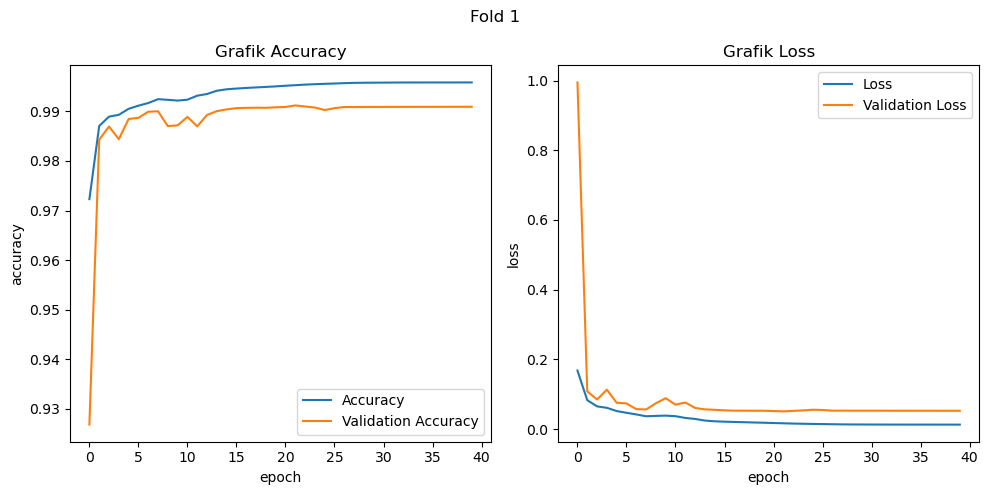

In [18]:
train_data(fold=1)

Train: 2548 - 2548
Valid: 48 - 48
Epoch 1/40
637/637 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9735 - dice_coef: 0.8482 - iou: 0.7540 - recall_1: 0.9232 - precision_1: 0.8231
Epoch 1: val_loss improved from inf to 0.99673, saving model to files\model_fold2.h5
637/637 [==============================] - 110s 167ms/step - loss: 0.1518 - accuracy: 0.9735 - dice_coef: 0.8482 - iou: 0.7540 - recall_1: 0.9232 - precision_1: 0.8231 - val_loss: 0.9967 - val_accuracy: 0.9268 - val_dice_coef: 0.0033 - val_iou: 0.0016 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/40
637/637 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9862 - dice_coef: 0.9182 - iou: 0.8542 - recall_1: 0.9397 - precision_1: 0.9267
Epoch 2: val_loss improved from 0.99673 to 0.71294, saving model to files\model_fold2.h5
637/637 [==============================] - 106s 166ms/step - loss: 0.0818 - accuracy: 0.9862 - dice_coef: 0.9182 - iou: 0.85

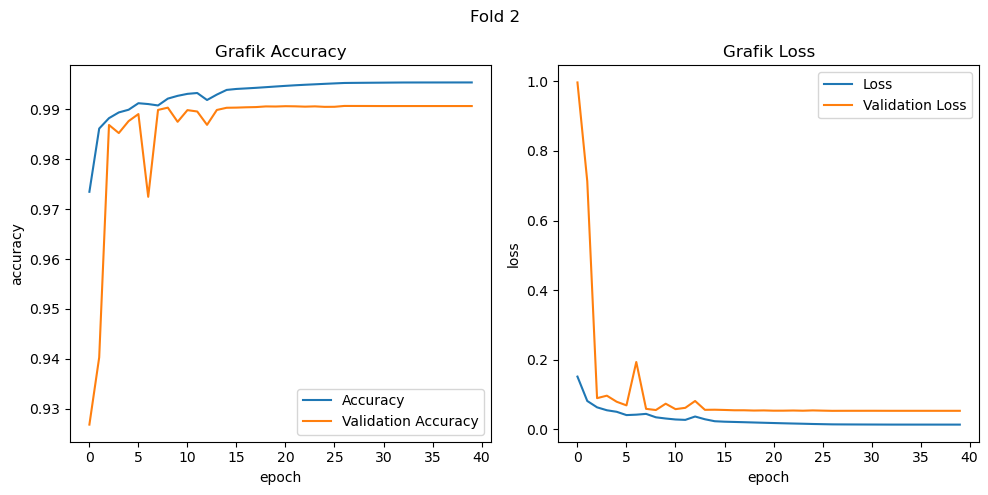

In [19]:
train_data(fold=2)

Train: 2548 - 2548
Valid: 48 - 48
Epoch 1/40
637/637 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9763 - dice_coef: 0.8462 - iou: 0.7529 - recall_2: 0.9185 - precision_2: 0.8413
Epoch 1: val_loss improved from inf to 0.99523, saving model to files\model_fold3.h5
637/637 [==============================] - 109s 167ms/step - loss: 0.1538 - accuracy: 0.9763 - dice_coef: 0.8462 - iou: 0.7529 - recall_2: 0.9185 - precision_2: 0.8413 - val_loss: 0.9952 - val_accuracy: 0.9268 - val_dice_coef: 0.0048 - val_iou: 0.0024 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/40
637/637 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9872 - dice_coef: 0.9198 - iou: 0.8579 - recall_2: 0.9398 - precision_2: 0.9319
Epoch 2: val_loss improved from 0.99523 to 0.18678, saving model to files\model_fold3.h5
637/637 [==============================] - 106s 166ms/step - loss: 0.0802 - accuracy: 0.9872 - dice_coef: 0.9198 - iou: 0.85

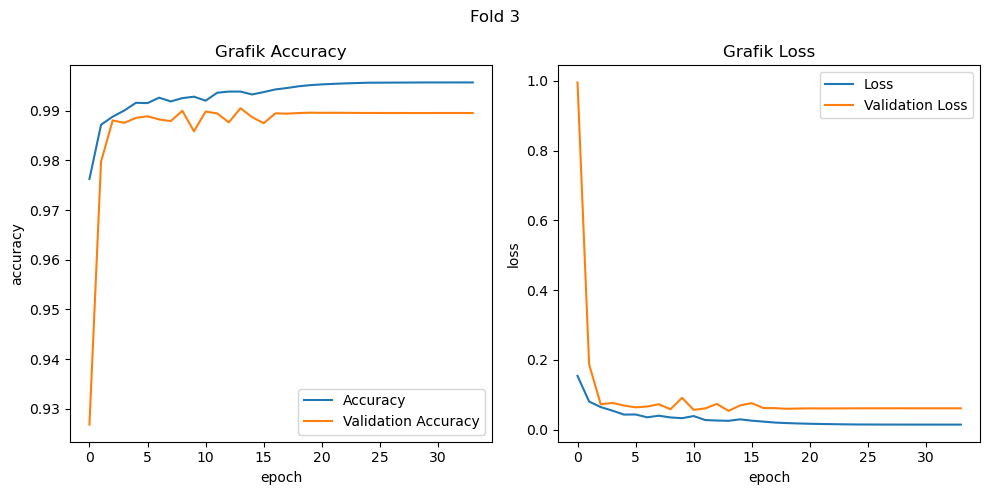

In [20]:
train_data(fold=3)

Train: 2548 - 2548
Valid: 48 - 48
Epoch 1/40
637/637 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9735 - dice_coef: 0.8464 - iou: 0.7550 - recall_3: 0.9216 - precision_3: 0.8100
Epoch 1: val_loss improved from inf to 0.99795, saving model to files\model_fold4.h5
637/637 [==============================] - 110s 168ms/step - loss: 0.1536 - accuracy: 0.9735 - dice_coef: 0.8464 - iou: 0.7550 - recall_3: 0.9216 - precision_3: 0.8100 - val_loss: 0.9979 - val_accuracy: 0.9268 - val_dice_coef: 0.0021 - val_iou: 0.0010 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/40
637/637 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9874 - dice_coef: 0.9215 - iou: 0.8603 - recall_3: 0.9419 - precision_3: 0.9293
Epoch 2: val_loss improved from 0.99795 to 0.07619, saving model to files\model_fold4.h5
637/637 [==============================] - 106s 166ms/step - loss: 0.0785 - accuracy: 0.9874 - dice_coef: 0.9215 - iou: 0.86

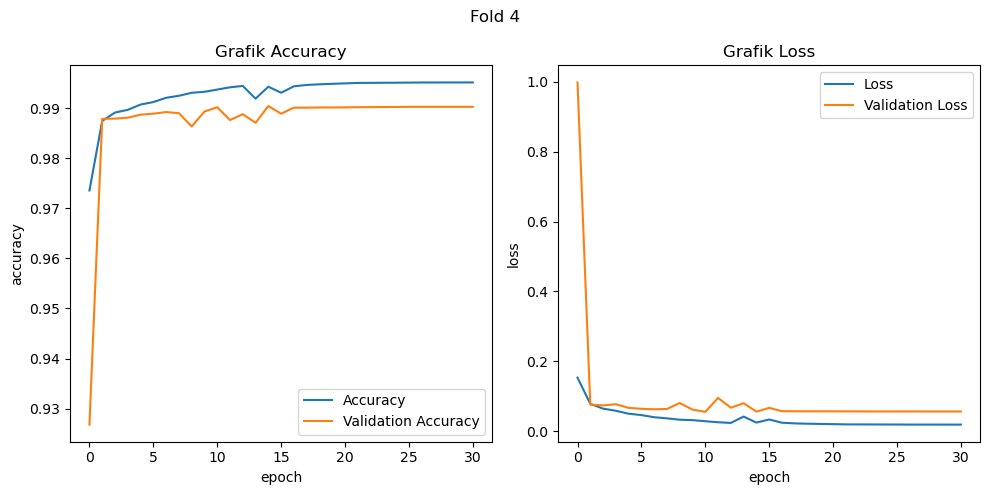

In [21]:
train_data(fold=4)

Train: 2576 - 2576
Valid: 48 - 48
Epoch 1/40
644/644 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9761 - dice_coef: 0.8409 - iou: 0.7453 - recall_4: 0.9200 - precision_4: 0.8307
Epoch 1: val_loss improved from inf to 0.98526, saving model to files\model_fold5.h5
644/644 [==============================] - 108s 162ms/step - loss: 0.1591 - accuracy: 0.9761 - dice_coef: 0.8409 - iou: 0.7453 - recall_4: 0.9200 - precision_4: 0.8307 - val_loss: 0.9853 - val_accuracy: 0.9269 - val_dice_coef: 0.0147 - val_iou: 0.0074 - val_recall_4: 5.8324e-04 - val_precision_4: 1.0000 - lr: 1.0000e-04
Epoch 2/40
644/644 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9868 - dice_coef: 0.9156 - iou: 0.8505 - recall_4: 0.9369 - precision_4: 0.9250
Epoch 2: val_loss improved from 0.98526 to 0.16333, saving model to files\model_fold5.h5
644/644 [==============================] - 104s 162ms/step - loss: 0.0844 - accuracy: 0.9868 - dice_coef: 0.9156 - iou: 0.8505 -

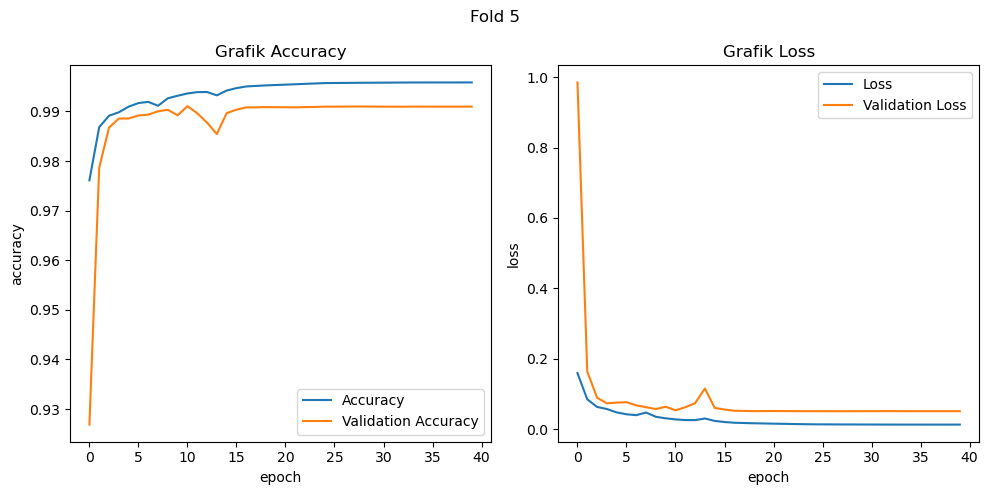

In [22]:
train_data(fold=5)

# Evaluate and Predict Data

In [23]:
def save_results(image, mask, y_pred, com_image_path, prediction_path, masked_path):
    ## i - m - yp - yp*i
    line = np.ones((H, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    
    y_pred = np.expand_dims(y_pred, axis=-1)    ## (512, 512, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (512, 512, 3)
    masked_image = image * y_pred
    y_pred *= 255
    
    # Save masked image
    cv2.imwrite(masked_path, masked_image)
    
    # Save prediction image
    cv2.imwrite(prediction_path, y_pred)
    
    image_text = cv2.putText(image, text="Original Image", org=(12,500), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
    mask_text = cv2.putText(mask, text="Ground Truth", org=(12,500), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
    y_pred_text = cv2.putText(y_pred, text="Prediction", org=(12,500), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
    masked_image_text = cv2.putText(masked_image, text="Combine", org=(12,500), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
    com_images = np.concatenate([image_text, line, mask_text, line, y_pred_text, line, masked_image_text], axis=1)
    
    # Save combination image
    cv2.imwrite(com_image_path, com_images)

In [24]:
""" Seeding """
# np.random.seed(42)
# tf.random.set_seed(42)

""" Directory for storing files """
create_dir("results")

def evaluate_data(fold=None):
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    # with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'TverskyLoss': TverskyLoss}):
        model = tf.keras.models.load_model("files/model_fold{}.h5".format(fold))
        
    """ Load the dataset """
    dataset_path = "./augment_data"
    train_path = os.path.join(dataset_path, "fold{}/train".format(fold))
    val_path = os.path.join(dataset_path, "fold{}/valid".format(fold))
    test_path = os.path.join(dataset_path, "fold{}/test".format(fold))
    
    train_x, train_y = load_data(train_path)
    val_x, val_y = load_data(val_path)
    test_x, test_y = load_data(test_path)
    print(f"Train\t: {len(train_x)} - {len(train_y)}")
    print(f"Val\t: {len(val_x)} - {len(val_y)}")
    print(f"Test\t: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    TRAIN_SCORE = []
    VAL_SCORE =[]
    TEST_SCORE = []
    
    start = time.time()
    
    for x, y in zip(test_x, test_y):
        """ Extract the name """
        name = x.split("\\")[-1].split(".")[0]
        
        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image / 255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)
        
        """ Saving the prediction for test dataset"""
        com_image_path = f"results/fold{fold}/combination/{name}.png"
        prediction_path = f"results/fold{fold}/prediction/{name}.png"
        slice_path = f"results/fold{fold}/masked/{name}.png"
        save_results(image, mask, y_pred, com_image_path, prediction_path, slice_path)

        """ Flatten the array """
        mask = mask.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(mask, y_pred)
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="micro")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="micro")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="micro")
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="micro")
        TEST_SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])
    
    for x, y in zip(train_x, train_y):
        """ Extract the name """
        name = x.split("\\")[-1].split(".")[0]
        
        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image / 255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Flatten the array """
        mask = mask.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(mask, y_pred)
        TRAIN_SCORE.append([name, acc_value])
        
    for x, y in zip(val_x, val_y):
        """ Extract the name """
        name = x.split("\\")[-1].split(".")[0]
        
        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image / 255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Flatten the array """
        mask = mask.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(mask, y_pred)
        VAL_SCORE.append([name, acc_value])


    """ Metrics values """
    print(f"Exec Predict Time : {round(time.time() - start, 2)} seconds")
    print("")
    print("Test Metrics")
    score_test = [s[1:] for s in TEST_SCORE]
    score_test = np.mean(score_test, axis=0)
    print(f"Accuracy\t: {score_test[0]:0.4f}")
    print(f"F1-Score\t: {score_test[1]:0.4f}")
    print(f"Mean IoU\t: {score_test[2]:0.4f}")
    print(f"Recall\t\t: {score_test[3]:0.4f}")
    print(f"Precision\t: {score_test[4]:0.4f}")
    
    print("")
    print("Train Metrics")
    score_train = [s[1:] for s in TRAIN_SCORE]
    score_train = np.mean(score_train, axis=0)
    print(f"Accuracy\t: {score_train[0]:0.4f}")
    
    print("")
    print("Validation Metrics")
    score_val = [s[1:] for s in VAL_SCORE]
    score_val = np.mean(score_val, axis=0)
    print(f"Accuracy\t: {score_val[0]:0.4f}")
    
    df_train = pd.DataFrame(TRAIN_SCORE, columns=["Image", "Train Accuracy"])
    df_val = pd.DataFrame(VAL_SCORE, columns=["Image", "Validation Accuracy"])
    df_test = pd.DataFrame(TEST_SCORE, columns=["Image", "Test Accuracy", "F1-Score", "Mean IoU", "Recall", "Precision"])
    df_train.to_csv("files/score_train_fold{}.csv".format(fold))
    df_val.to_csv("files/score_val_fold{}.csv".format(fold))
    df_test.to_csv("files/score_test_fold{}.csv".format(fold))

In [25]:
evaluate_data(fold=1)

Train	: 2548 - 2548
Val	: 48 - 48
Test	: 92 - 92
1/1 [==============================] - 0s 16ms/step
Exec Predict Time : 197.52 seconds

Test Metrics
Accuracy	: 0.9046
F1-Score	: 0.9441
Mean IoU	: 0.9017
Recall		: 0.9949
Precision	: 0.9046

Train Metrics
Accuracy	: 0.9155

Validation Metrics
Accuracy	: 0.9229


In [26]:
evaluate_data(fold=2)

Train	: 2548 - 2548
Val	: 48 - 48
Test	: 92 - 92
1/1 [==============================] - 0s 26ms/step
Exec Predict Time : 199.61 seconds

Test Metrics
Accuracy	: 0.9277
F1-Score	: 0.9590
Mean IoU	: 0.9242
Recall		: 0.9949
Precision	: 0.9277

Train Metrics
Accuracy	: 0.9095

Validation Metrics
Accuracy	: 0.9221


In [27]:
evaluate_data(fold=3)

Train	: 2548 - 2548
Val	: 48 - 48
Test	: 92 - 92
1/1 [==============================] - 0s 21ms/step
Exec Predict Time : 203.77 seconds

Test Metrics
Accuracy	: 0.9123
F1-Score	: 0.9493
Mean IoU	: 0.9069
Recall		: 0.9930
Precision	: 0.9123

Train Metrics
Accuracy	: 0.9125

Validation Metrics
Accuracy	: 0.9216


In [28]:
evaluate_data(fold=4)

Train	: 2548 - 2548
Val	: 48 - 48
Test	: 92 - 92
1/1 [==============================] - 0s 28ms/step
Exec Predict Time : 210.0 seconds

Test Metrics
Accuracy	: 0.9041
F1-Score	: 0.9438
Mean IoU	: 0.8994
Recall		: 0.9932
Precision	: 0.9041

Train Metrics
Accuracy	: 0.9146

Validation Metrics
Accuracy	: 0.9212


In [29]:
evaluate_data(fold=5)

Train	: 2576 - 2576
Val	: 48 - 48
Test	: 88 - 88
1/1 [==============================] - 0s 19ms/step
Exec Predict Time : 213.61 seconds

Test Metrics
Accuracy	: 0.9002
F1-Score	: 0.9418
Mean IoU	: 0.8950
Recall		: 0.9928
Precision	: 0.9002

Train Metrics
Accuracy	: 0.9165

Validation Metrics
Accuracy	: 0.9224


# Reconstruct Predict Data and Ground Truth

In [30]:
def load_pred(fold=None):
    tmp_test_images = pd.DataFrame({
        'pred_image_path': sorted(glob(os.path.join("./results/fold{}/prediction/".format(fold), "*.png"))),
        'masked_image_path': sorted(glob(os.path.join("./results/fold{}/masked/".format(fold), "*.png"))),
    })
    
    return tmp_test_images.pred_image_path.tolist(), tmp_test_images.masked_image_path.tolist()

In [31]:
def load_truth_and_mask(fold=None):
    tmp_test_images = pd.DataFrame({
        'truth_image_path': sorted(glob(os.path.join("./augment_data/fold{}/test/image/".format(fold), "*.png"))),
        'mask_image_path': sorted(glob(os.path.join("./augment_data/fold{}/test/mask/".format(fold), "*.png"))),
    })
    
    return tmp_test_images.truth_image_path.tolist(), tmp_test_images.mask_image_path.tolist()

In [32]:
def combine_images(columns, space, images, fold=None, masked=None, prediction=None, truth_img=None, truth_mask=None):
    if masked == True:
        rows = len(images) // columns
        if len(images) % columns:
            rows += 1
        width_max = max([Image.open(image).width for image in images])
        height_max = max([Image.open(image).height for image in images])
        background_width = width_max*columns + (space*columns)-space
        background_height = height_max*rows + (space*rows)-space
        background = Image.new('RGB', (background_width, background_height), (255, 255, 255))
        x = 0
        y = 0
        for i, image in enumerate(images):
            name = image.split("\\")[-1].split(".")[0]
            name = name[0:5]
            img = Image.open(image)
            x_offset = int((width_max-img.width)/2)
            y_offset = int((height_max-img.height)/2)
            background.paste(img, (x+x_offset, y+y_offset))
            x += width_max + space
            if (i+1) % columns == 0:
                y += height_max + space
                x = 0
                
        background.save('./results/fold{}/merge_masked/{}.png'.format(fold, name))
        
    elif prediction == True:
        rows = len(images) // columns
        if len(images) % columns:
            rows += 1
        width_max = max([Image.open(image).width for image in images])
        height_max = max([Image.open(image).height for image in images])
        background_width = width_max*columns + (space*columns)-space
        background_height = height_max*rows + (space*rows)-space
        background = Image.new('RGB', (background_width, background_height), (255, 255, 255))
        x = 0
        y = 0
        name = None
        for i, image in enumerate(images):
            name = image.split("\\")[-1].split(".")[0]
            name = name[0:5]
            img = Image.open(image)
            x_offset = int((width_max-img.width)/2)
            y_offset = int((height_max-img.height)/2)
            background.paste(img, (x+x_offset, y+y_offset))
            x += width_max + space
            if (i+1) % columns == 0:
                y += height_max + space
                x = 0
                
        background.save('./results/fold{}/merge_prediction/{}.png'.format(fold, name))
        
    elif truth_img == True:
        rows = len(images) // columns
        if len(images) % columns:
            rows += 1
        width_max = max([Image.open(image).width for image in images])
        height_max = max([Image.open(image).height for image in images])
        background_width = width_max*columns + (space*columns)-space
        background_height = height_max*rows + (space*rows)-space
        background = Image.new('RGB', (background_width, background_height), (255, 255, 255))
        x = 0
        y = 0
        name = None
        for i, image in enumerate(images):
            name = image.split("\\")[-1].split(".")[0]
            name = name[0:5]
            img = Image.open(image)
            x_offset = int((width_max-img.width)/2)
            y_offset = int((height_max-img.height)/2)
            background.paste(img, (x+x_offset, y+y_offset))
            x += width_max + space
            if (i+1) % columns == 0:
                y += height_max + space
                x = 0
                
        background.save('./results/fold{}/merge_ground_truth/{}.png'.format(fold, name))
        
    elif truth_mask == True:
        rows = len(images) // columns
        if len(images) % columns:
            rows += 1
        width_max = max([Image.open(image).width for image in images])
        height_max = max([Image.open(image).height for image in images])
        background_width = width_max*columns + (space*columns)-space
        background_height = height_max*rows + (space*rows)-space
        background = Image.new('RGB', (background_width, background_height), (255, 255, 255))
        x = 0
        y = 0
        name = None
        for i, image in enumerate(images):
            name = image.split("\\")[-1].split(".")[0]
            name = name[0:5]
            img = Image.open(image)
            x_offset = int((width_max-img.width)/2)
            y_offset = int((height_max-img.height)/2)
            background.paste(img, (x+x_offset, y+y_offset))
            x += width_max + space
            if (i+1) % columns == 0:
                y += height_max + space
                x = 0
                
        background.save('./results/fold{}/merge_mask/{}.png'.format(fold, name))
    else:
        return

In [33]:
pred_img, masked_img = load_pred(1)
truth_img, mask_img = load_truth_and_mask(1)

y = 0
tmp_truth = []
tmp_mask = []
tmp_masked = []
tmp_pred = []

for i in range(int(len(masked_img)/4)):
    for j in range(4):
        tmp_mask.append(mask_img[y])
        tmp_truth.append(truth_img[y])
        tmp_masked.append(masked_img[y])
        tmp_pred.append(pred_img[y])

        y= y+1 
    combine_images(columns=2, space=0, images=tmp_truth, fold=1, truth_img=True)
    combine_images(columns=2, space=0, images=tmp_mask, fold=1, truth_mask=True)
    combine_images(columns=2, space=0, images=tmp_masked, fold=1, masked=True)
    combine_images(columns=2, space=0, images=tmp_pred, fold=1, prediction=True)
    tmp_truth = []
    tmp_mask = []
    tmp_masked = []
    tmp_pred = []


In [34]:
pred_img, masked_img = load_pred(2)
truth_img, mask_img = load_truth_and_mask(2)

y = 0
tmp_truth = []
tmp_mask = []
tmp_masked = []
tmp_pred = []

for i in range(int(len(masked_img)/4)):
    for j in range(4):
        tmp_mask.append(mask_img[y])
        tmp_truth.append(truth_img[y])
        tmp_masked.append(masked_img[y])
        tmp_pred.append(pred_img[y])

        y= y+1 
    combine_images(columns=2, space=0, images=tmp_truth, fold=2, truth_img=True)
    combine_images(columns=2, space=0, images=tmp_mask, fold=2, truth_mask=True)
    combine_images(columns=2, space=0, images=tmp_masked, fold=2, masked=True)
    combine_images(columns=2, space=0, images=tmp_pred, fold=2, prediction=True)
    tmp_truth = []
    tmp_mask = []
    tmp_masked = []
    tmp_pred = []

In [35]:
pred_img, masked_img = load_pred(3)
truth_img, mask_img = load_truth_and_mask(3)

y = 0
tmp_truth = []
tmp_mask = []
tmp_masked = []
tmp_pred = []

for i in range(int(len(masked_img)/4)):
    for j in range(4):
        tmp_mask.append(mask_img[y])
        tmp_truth.append(truth_img[y])
        tmp_masked.append(masked_img[y])
        tmp_pred.append(pred_img[y])

        y= y+1 
    combine_images(columns=2, space=0, images=tmp_truth, fold=3, truth_img=True)
    combine_images(columns=2, space=0, images=tmp_mask, fold=3, truth_mask=True)
    combine_images(columns=2, space=0, images=tmp_masked, fold=3, masked=True)
    combine_images(columns=2, space=0, images=tmp_pred, fold=3, prediction=True)
    tmp_truth = []
    tmp_mask = []
    tmp_masked = []
    tmp_pred = []

In [36]:
pred_img, masked_img = load_pred(4)
truth_img, mask_img = load_truth_and_mask(4)

y = 0
tmp_truth = []
tmp_mask = []
tmp_masked = []
tmp_pred = []

for i in range(int(len(masked_img)/4)):
    for j in range(4):
        tmp_mask.append(mask_img[y])
        tmp_truth.append(truth_img[y])
        tmp_masked.append(masked_img[y])
        tmp_pred.append(pred_img[y])

        y= y+1 
    combine_images(columns=2, space=0, images=tmp_truth, fold=4, truth_img=True)
    combine_images(columns=2, space=0, images=tmp_mask, fold=4, truth_mask=True)
    combine_images(columns=2, space=0, images=tmp_masked, fold=4, masked=True)
    combine_images(columns=2, space=0, images=tmp_pred, fold=4, prediction=True)
    tmp_truth = []
    tmp_mask = []
    tmp_masked = []
    tmp_pred = []

In [37]:
pred_img, masked_img = load_pred(5)
truth_img, mask_img = load_truth_and_mask(5)

y = 0
tmp_truth = []
tmp_mask = []
tmp_masked = []
tmp_pred = []

for i in range(int(len(masked_img)/4)):
    for j in range(4):
        tmp_mask.append(mask_img[y])
        tmp_truth.append(truth_img[y])
        tmp_masked.append(masked_img[y])
        tmp_pred.append(pred_img[y])

        y= y+1 
    combine_images(columns=2, space=0, images=tmp_truth, fold=5, truth_img=True)
    combine_images(columns=2, space=0, images=tmp_mask, fold=5, truth_mask=True)
    combine_images(columns=2, space=0, images=tmp_masked, fold=5, masked=True)
    combine_images(columns=2, space=0, images=tmp_pred, fold=5, prediction=True)
    tmp_truth = []
    tmp_mask = []
    tmp_masked = []
    tmp_pred = []

In [38]:
def merge_load_pred(fold=None):
    tmp_test_images = pd.DataFrame({
        'pred_image_path': sorted(glob(os.path.join("./results/fold{}/merge_prediction/".format(fold), "*.png"))),
        'masked_image_path': sorted(glob(os.path.join("./results/fold{}/merge_masked/".format(fold), "*.png"))),
    })
    
    return tmp_test_images.pred_image_path.tolist(), tmp_test_images.masked_image_path.tolist()

In [39]:
def merge_load_truth_and_mask(fold=None):
    tmp_test_images = pd.DataFrame({
        'truth_image_path': sorted(glob(os.path.join("./results/fold{}/merge_ground_truth/".format(fold), "*.png"))),
        'mask_image_path': sorted(glob(os.path.join("./results/fold{}/merge_mask/".format(fold), "*.png"))),
    })
    
    return tmp_test_images.truth_image_path.tolist(), tmp_test_images.mask_image_path.tolist()

In [40]:
def save_merge(image, mask, y_pred, masked_image, combination_image_path):
    line = np.ones((1024, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1)    ## (1024, 1024, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (1024, 1024, 3)
    
    y_pred = np.expand_dims(y_pred, axis=-1)    ## (1024, 1024, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (1024, 1024, 3)
    
    image_text = cv2.putText(image, text="Original Image", org=(12,1000), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(0, 0, 255), thickness=3)
    mask_text = cv2.putText(mask, text="Ground Truth", org=(12,1000), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(0, 0, 255), thickness=3)
    y_pred_text = cv2.putText(y_pred, text="Prediction", org=(12,1000), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(0, 0, 255), thickness=3)
    masked_image_text = cv2.putText(masked_image, text="Combine", org=(12,1000), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(0, 0, 255), thickness=3)
    com_images = np.concatenate([image_text, line, mask_text, line, y_pred_text, line, masked_image_text], axis=1)

    # Save combination image
    cv2.imwrite(combination_image_path, com_images)

In [41]:
end_ori, end_mask = merge_load_truth_and_mask(1)
end_pred, end_masked = merge_load_pred(1)

for x, y, a, b in zip(end_ori, end_mask, end_pred, end_masked):
    """ Extract the name """
    name = x.split("\\")[-1].split(".")[0]
        
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the prediction """
    pred = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the masked image """
    masked = cv2.imread(b, cv2.IMREAD_COLOR)
    
    com_image_path = f"./results/fold1/merge_combination/{name}.png"
    save_merge(image, mask, pred, masked, com_image_path)

In [42]:
end_ori, end_mask = merge_load_truth_and_mask(2)
end_pred, end_masked = merge_load_pred(2)

for x, y, a, b in zip(end_ori, end_mask, end_pred, end_masked):
    """ Extract the name """
    name = x.split("\\")[-1].split(".")[0]
        
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the prediction """
    pred = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the masked image """
    masked = cv2.imread(b, cv2.IMREAD_COLOR)
    
    com_image_path = f"./results/fold2/merge_combination/{name}.png"
    save_merge(image, mask, pred, masked, com_image_path)

In [43]:
end_ori, end_mask = merge_load_truth_and_mask(3)
end_pred, end_masked = merge_load_pred(3)

for x, y, a, b in zip(end_ori, end_mask, end_pred, end_masked):
    """ Extract the name """
    name = x.split("\\")[-1].split(".")[0]
        
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the prediction """
    pred = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the masked image """
    masked = cv2.imread(b, cv2.IMREAD_COLOR)
    
    com_image_path = f"./results/fold3/merge_combination/{name}.png"
    save_merge(image, mask, pred, masked, com_image_path)

In [44]:
end_ori, end_mask = merge_load_truth_and_mask(4)
end_pred, end_masked = merge_load_pred(4)

for x, y, a, b in zip(end_ori, end_mask, end_pred, end_masked):
    """ Extract the name """
    name = x.split("\\")[-1].split(".")[0]
        
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the prediction """
    pred = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the masked image """
    masked = cv2.imread(b, cv2.IMREAD_COLOR)
    
    com_image_path = f"./results/fold4/merge_combination/{name}.png"
    save_merge(image, mask, pred, masked, com_image_path)

In [45]:
end_ori, end_mask = merge_load_truth_and_mask(5)
end_pred, end_masked = merge_load_pred(5)

for x, y, a, b in zip(end_ori, end_mask, end_pred, end_masked):
    """ Extract the name """
    name = x.split("\\")[-1].split(".")[0]
        
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the prediction """
    pred = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    
    """ Reading the masked image """
    masked = cv2.imread(b, cv2.IMREAD_COLOR)
    
    com_image_path = f"./results/fold5/merge_combination/{name}.png"
    save_merge(image, mask, pred, masked, com_image_path)

# Finish